<a href="https://colab.research.google.com/github/emanfj/Healthcare-Disparities-Analysis/blob/main/census_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=860ea96970def65d4c2155938303d9e600715a05b79aff6b70a586bab106c464
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# necessary imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, isnull
from pyspark.sql.functions import lit,mean,when, greatest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# starting spark session
spark = SparkSession.builder.appName("Census").getOrCreate()

In [ ]:
# loading data
demographics = spark.read.csv('/content/drive/MyDrive/2017_census.csv',header=True, inferSchema=True)

In [ ]:
# getting the shape of the dataframe
demographics_rows=demographics.count()
demographics_columns=len(demographics.columns)
print('Rows for demographics: ',demographics_rows)
print('Columns for demographics: ',demographics_columns)

Rows for demographics:  74001
Columns for demographics:  37


In [ ]:
demographics.printSchema()

root
 |-- TractId: long (nullable = true)
 |-- State: string (nullable = true)
 |-- County: string (nullable = true)
 |-- TotalPop: integer (nullable = true)
 |-- Men: integer (nullable = true)
 |-- Women: integer (nullable = true)
 |-- Hispanic: double (nullable = true)
 |-- White: double (nullable = true)
 |-- Black: double (nullable = true)
 |-- Native: double (nullable = true)
 |-- Asian: double (nullable = true)
 |-- Pacific: double (nullable = true)
 |-- VotingAgeCitizen: integer (nullable = true)
 |-- Income: double (nullable = true)
 |-- IncomeErr: double (nullable = true)
 |-- IncomePerCap: double (nullable = true)
 |-- IncomePerCapErr: double (nullable = true)
 |-- Poverty: double (nullable = true)
 |-- ChildPoverty: double (nullable = true)
 |-- Professional: double (nullable = true)
 |-- Service: double (nullable = true)
 |-- Office: double (nullable = true)
 |-- Construction: double (nullable = true)
 |-- Production: double (nullable = true)
 |-- Drive: double (nullable = 

In [ ]:
#formatting of columns for demographics data
demographics = demographics \
    .withColumnRenamed("TotalPop", "TotalPopulation") \
    .withColumnRenamed("Hispanic", "HispanicPercentage") \
    .withColumnRenamed("White", "WhitePercentage") \
    .withColumnRenamed("Black", "BlackPercentage") \
    .withColumnRenamed("Native", "NativePercentage") \
    .withColumnRenamed("Asian", "AsianPercentage") \
    .withColumnRenamed("Pacific", "PacificPercentage") \
    .withColumnRenamed("Income", "MedianHouseholdIncome") \
    .withColumnRenamed("IncomeErr", "MedianHouseholdIncomeError") \
    .withColumnRenamed("IncomePerCap", "IncomePerCapita") \
    .withColumnRenamed("IncomePerCapErr", "IncomePerCapitaError") \
    .withColumnRenamed("OtherTransp", "OtherTransportation")  \
    .withColumnRenamed("MeanCommute", "MeanCommuteTime")

In [ ]:
# filtering out rows that have no recorded population
demographics = demographics.filter(demographics.TotalPopulation > 0)
demographics.count()

73305

In [ ]:
# percentage of missing values in each column
missing_percentage = demographics.select([(count(when(isnan(c) | col(c).isNull(), c))/count(lit(1))).alias(c) for c in demographics.columns])
missing_percentage.show()

+-------+-----+------+---------------+---+-----+------------------+---------------+---------------+----------------+---------------+-----------------+----------------+---------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|TractId|State|County|TotalPopulation|Men|Women|HispanicPercentage|WhitePercentage|BlackPercentage|NativePercentage|AsianPercentage|PacificPercentage|VotingAgeCitizen|MedianHouseholdIncome|MedianHouseholdIncomeError|     IncomePerCapita|IncomePerCapitaError|             Poverty|        ChildPoverty|        Professional|            

In [ ]:
# get mean values for each numeric column
numeric_columns = [col_name for col_name, col_type in demographics.dtypes if col_type != 'string']
means = demographics.select(*(mean(col(c)).alias(c) for c in numeric_columns))

# extract mean values from DataFrame
mean_values = means.first().asDict()

# fill null values with mean for numeric columns
for col_name in numeric_columns:
    demographics = demographics.na.fill(mean_values[col_name], [col_name])

# show df after imputation
demographics.show()

+----------+-------+--------------+---------------+----+-----+------------------+---------------+---------------+----------------+---------------+-----------------+----------------+---------------------+--------------------------+---------------+--------------------+-------+------------+------------+-------+------+------------+----------+-----+-------+-------+----+-------------------+----------+---------------+--------+-----------+----------+------------+----------+------------+
|   TractId|  State|        County|TotalPopulation| Men|Women|HispanicPercentage|WhitePercentage|BlackPercentage|NativePercentage|AsianPercentage|PacificPercentage|VotingAgeCitizen|MedianHouseholdIncome|MedianHouseholdIncomeError|IncomePerCapita|IncomePerCapitaError|Poverty|ChildPoverty|Professional|Service|Office|Construction|Production|Drive|Carpool|Transit|Walk|OtherTransportation|WorkAtHome|MeanCommuteTime|Employed|PrivateWork|PublicWork|SelfEmployed|FamilyWork|Unemployment|
+----------+-------+------------

In [ ]:
# find duplicate rows across all cols
demographics.exceptAll(demographics.dropDuplicates()).show()

+-------+-----+------+---------------+---+-----+------------------+---------------+---------------+----------------+---------------+-----------------+----------------+---------------------+--------------------------+---------------+--------------------+-------+------------+------------+-------+------+------------+----------+-----+-------+-------+----+-------------------+----------+---------------+--------+-----------+----------+------------+----------+------------+
|TractId|State|County|TotalPopulation|Men|Women|HispanicPercentage|WhitePercentage|BlackPercentage|NativePercentage|AsianPercentage|PacificPercentage|VotingAgeCitizen|MedianHouseholdIncome|MedianHouseholdIncomeError|IncomePerCapita|IncomePerCapitaError|Poverty|ChildPoverty|Professional|Service|Office|Construction|Production|Drive|Carpool|Transit|Walk|OtherTransportation|WorkAtHome|MeanCommuteTime|Employed|PrivateWork|PublicWork|SelfEmployed|FamilyWork|Unemployment|
+-------+-----+------+---------------+---+-----+------------

In [ ]:
# display unique values in string dtype cols
demographics.select("State","County").distinct().show(50)

+-------------+--------------------+
|        State|              County|
+-------------+--------------------+
|        Idaho|      Benewah County|
|         Iowa|      Carroll County|
|         Iowa|  Cerro Gordo County|
|     Kentucky|       Barren County|
|     Kentucky|         Bell County|
|     Kentucky|      Bracken County|
|  Mississippi|       Jasper County|
|     Missouri|         Knox County|
|     Missouri|      Laclede County|
|      Montana|       McCone County|
|     New York|       Queens County|
|      Alabama|      Chilton County|
|       Alaska|Juneau City and B...|
|       Alaska|    Nome Census Area|
|      Florida|       Martin County|
|        Idaho|   Clearwater County|
|      Indiana|       Greene County|
|         Iowa|       Dallas County|
|         Iowa|          Lee County|
|    Minnesota|       Becker County|
|    Minnesota|      Goodhue County|
|  Mississippi|      Bolivar County|
|   California|       Madera County|
|      Florida|      Osceola County|
|

+----------+-------+--------------+-------------------+
|   TractId|  State|        County| AgeDependencyRatio|
+----------+-------+--------------+-------------------+
|1001020100|Alabama|Autauga County|0.31130063965884863|
|1001020200|Alabama|Autauga County|0.31476997578692495|
|1001020300|Alabama|Autauga County| 0.3649193548387097|
|1001020400|Alabama|Autauga County| 0.3101013202333436|
|1001020500|Alabama|Autauga County|0.37847558445151475|
|1001020600|Alabama|Autauga County|0.34722739114253814|
|1001020700|Alabama|Autauga County| 0.3475177304964539|
|1001020801|Alabama|Autauga County|0.34674063800277394|
|1001020802|Alabama|Autauga County|0.37403006789524734|
|1001020900|Alabama|Autauga County|0.30934182590233544|
|1001021000|Alabama|Autauga County|0.31144465290806755|
|1001021100|Alabama|Autauga County| 0.2546756864305611|
|1003010100|Alabama|Baldwin County|0.22406384284837325|
|1003010200|Alabama|Baldwin County| 0.4144965277777778|
|1003010300|Alabama|Baldwin County| 0.3921598770

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (73305,) and arg 1 with shape (73303,).

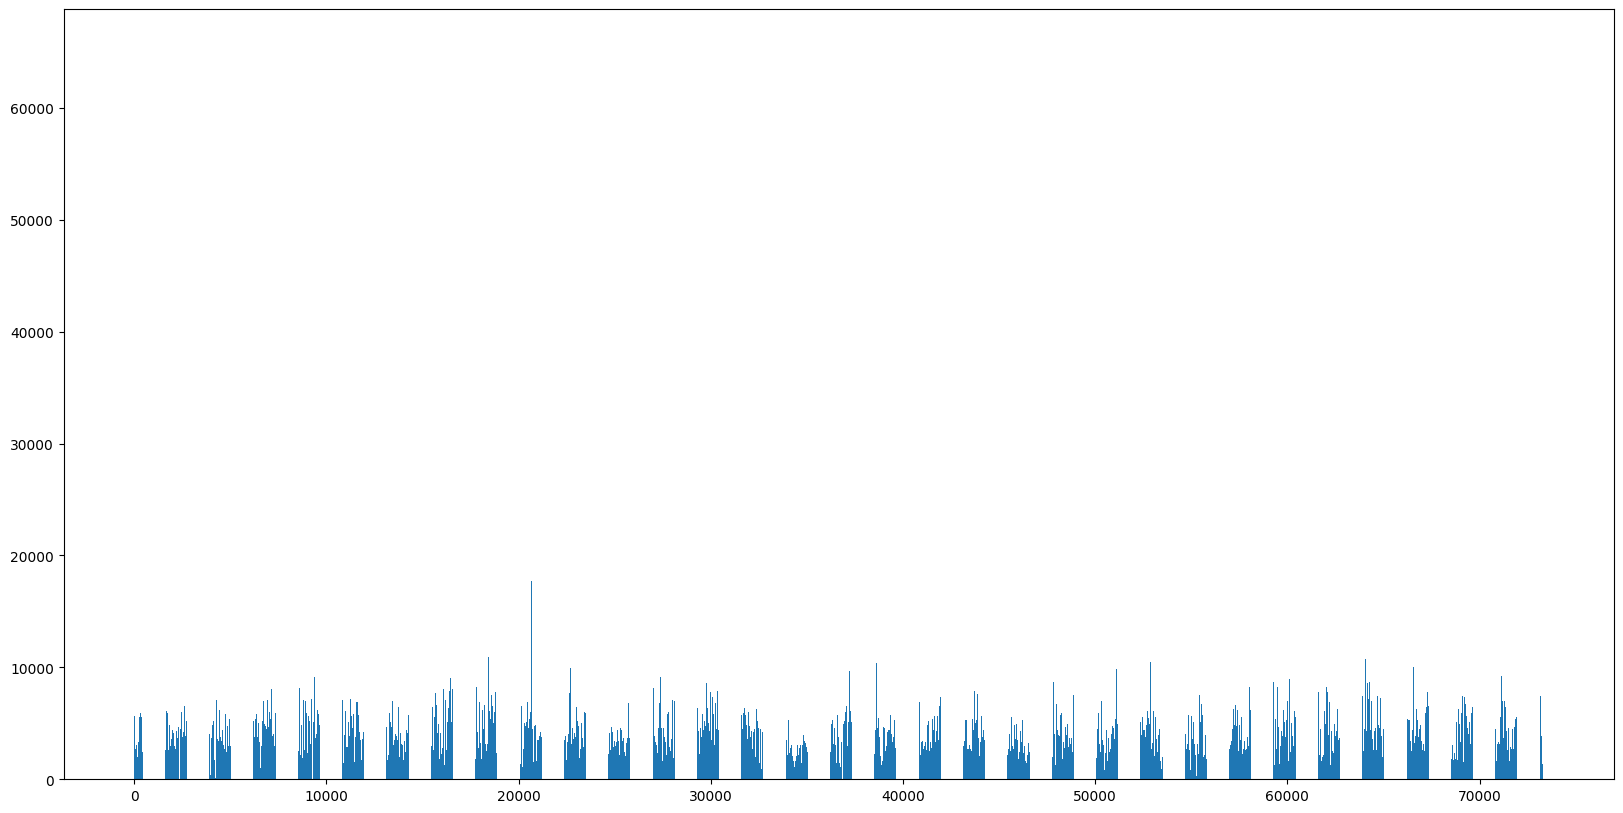

In [ ]:
"""deriving a new column for ratio of dependent population (excluding elderly for lack of information)
formula -> population under 18 / population above 18 """

demographics = demographics.withColumn('AgeDependencyRatio', (col('TotalPopulation')-col('VotingAgeCitizen')) / col('VotingAgeCitizen'))
demographics.select("TractId","State","County","AgeDependencyRatio").show()

# collecting the data for visualization
tract_ids = demographics.select("TractId").rdd.flatMap(lambda x: x).collect()
total_population = demographics.select("TotalPopulation").rdd.flatMap(lambda x: x).collect()
age_dependency_ratio = demographics.select("AgeDependencyRatio").rdd.flatMap(lambda x: x).collect()

# filtering out the none values
age_dependency_ratio_filtered = [ratio for ratio in age_dependency_ratio if ratio is not None]

# plotting the grouped bar chart
plt.figure(figsize=(20, 10))
bar_width = 0.5
index = np.arange(len(tract_ids))

plt.bar(index, total_population, bar_width, label='Total Population')
plt.bar(index + bar_width, age_dependency_ratio_filtered, bar_width, label='Age Dependency Ratio')

plt.xlabel('Census Tract')
plt.ylabel('Population')
plt.title('Total Population and Age Dependency Ratio by Census Tract')
plt.xticks(index + bar_width / 2, tract_ids, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

+----------+-------+--------------+----------------------+
|   TractId|  State|        County|HouseholdIncomeBracket|
+----------+-------+--------------+----------------------+
|1001020100|Alabama|Autauga County|                Middle|
|1001020200|Alabama|Autauga County|                Middle|
|1001020300|Alabama|Autauga County|                Middle|
|1001020400|Alabama|Autauga County|                Middle|
|1001020500|Alabama|Autauga County|                Middle|
|1001020600|Alabama|Autauga County|                Middle|
|1001020700|Alabama|Autauga County|                Middle|
|1001020801|Alabama|Autauga County|                  High|
|1001020802|Alabama|Autauga County|                Middle|
|1001020900|Alabama|Autauga County|                Middle|
|1001021000|Alabama|Autauga County|                Middle|
|1001021100|Alabama|Autauga County|                Middle|
|1003010100|Alabama|Baldwin County|                Middle|
|1003010200|Alabama|Baldwin County|                Middl

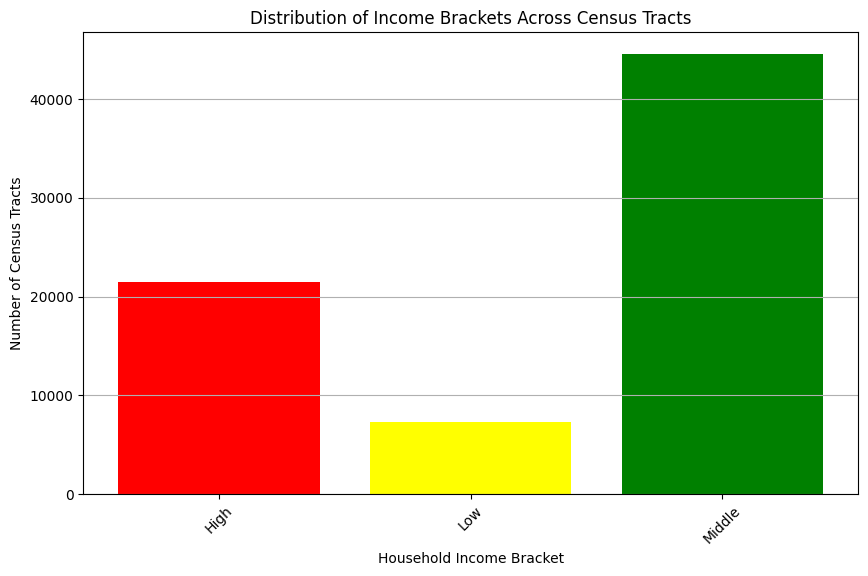

In [ ]:
# deriving a column for income bracket for each census tract
demographics = demographics.withColumn('HouseholdIncomeBracket',
                                       when(col('MedianHouseholdIncome') < 30000, 'Low')
                                       .when((col('MedianHouseholdIncome') >= 30000) & (col('MedianHouseholdIncome') < 70000), 'Middle')
                                       .otherwise('High'))

demographics.select("TractId","State","County","HouseholdIncomeBracket").show(30)

# collecting the data
income_bracket_data = demographics.groupBy('HouseholdIncomeBracket').count().collect()
income_brackets = [row['HouseholdIncomeBracket'] for row in income_bracket_data]
counts = [row['count'] for row in income_bracket_data]

# plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(income_brackets, counts, color=['red', 'yellow', 'green'])
plt.title("Distribution of Income Brackets Across Census Tracts")
plt.xlabel("Household Income Bracket")
plt.ylabel("Number of Census Tracts")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

+----------+-------+--------------+----------------------+
|   TractId|  State|        County|SimpsonsDiversityIndex|
+----------+-------+--------------+----------------------+
|1001020100|Alabama|Autauga County|    0.2518069999999999|
|1001020200|Alabama|Autauga County|    0.5296979999999999|
|1001020300|Alabama|Autauga County|    0.5462779999999999|
|1001020400|Alabama|Autauga County|    0.3409050000000001|
|1001020500|Alabama|Autauga County|    0.3714369999999999|
|1001020600|Alabama|Autauga County|    0.4362499999999999|
|1001020700|Alabama|Autauga County|   0.37119499999999983|
|1001020801|Alabama|Autauga County|              0.248201|
|1001020802|Alabama|Autauga County|    0.3071710000000001|
|1001020900|Alabama|Autauga County|    0.2473740000000001|
|1001021000|Alabama|Autauga County|   0.42259800000000014|
|1001021100|Alabama|Autauga County|              0.504682|
|1003010100|Alabama|Baldwin County|              0.395385|
|1003010200|Alabama|Baldwin County|    0.237228000000000

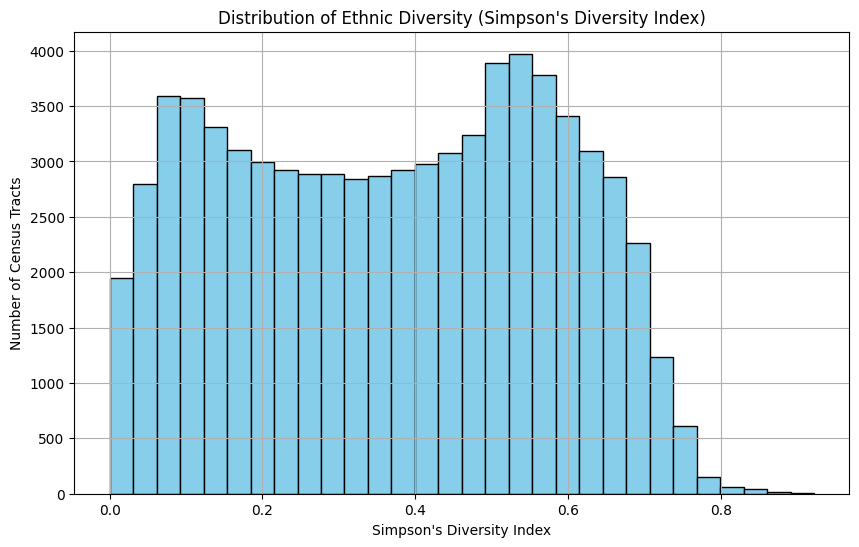

In [ ]:
"""deriving a column for ethnic diversity based on Simpson's Diversity Index
formula -> (1 - (sum of squared error of each ethnic group))
the values lie between 0 and 1 with values closer to 0 indicating low diversity
and values closer to 1 indicating high diversity and ethnic distribution"""

demographics = demographics.withColumn('SimpsonsDiversityIndex', 1 -
                                       (((col('HispanicPercentage')/100)**2) +
                                        ((col('WhitePercentage')/100)** 2) +
                                        ((col('BlackPercentage')/100)** 2) +
                                        ((col('NativePercentage')/100)** 2) +
                                        ((col('AsianPercentage')/100)** 2) +
                                        ((col('PacificPercentage')/100)** 2)))

demographics.select('TractId', 'State', 'County', 'SimpsonsDiversityIndex').show()

# collecting data for visualization
diversity_data = demographics.select('SimpsonsDiversityIndex').collect()
diversity_indices = [row['SimpsonsDiversityIndex'] for row in diversity_data]

# plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(diversity_indices, bins=30, edgecolor='black', color='skyblue')
plt.title("Distribution of Ethnic Diversity (Simpson's Diversity Index)")
plt.xlabel("Simpson's Diversity Index")
plt.ylabel('Number of Census Tracts')
plt.grid(True)
plt.show()


+----------+-------+--------------+------------------+
|   TractId|  State|        County|       GenderRatio|
+----------+-------+--------------+------------------+
|1001020100|Alabama|Autauga County|0.9503171247357294|
|1001020200|Alabama|Autauga County|1.1611940298507464|
|1001020300|Alabama|Autauga County|0.8277537796976242|
|1001020400|Alabama|Autauga County| 0.883053839364519|
|1001020500|Alabama|Autauga County|1.0291183058440236|
|1001020600|Alabama|Autauga County|0.9514824797843666|
|1001020700|Alabama|Autauga County|0.7440081591024987|
|1001020801|Alabama|Autauga County|1.0543018335684062|
|1001020802|Alabama|Autauga County|0.9389221556886228|
|1001020900|Alabama|Autauga County| 1.017997382198953|
|1001021000|Alabama|Autauga County|1.0619469026548674|
|1001021100|Alabama|Autauga County|0.8925570228091236|
|1003010100|Alabama|Baldwin County|1.1936193619361937|
|1003010200|Alabama|Baldwin County|0.8762233736327001|
|1003010300|Alabama|Baldwin County|0.9358700299273194|
|100301040

TypeError: '<=' not supported between instances of 'float' and 'NoneType'

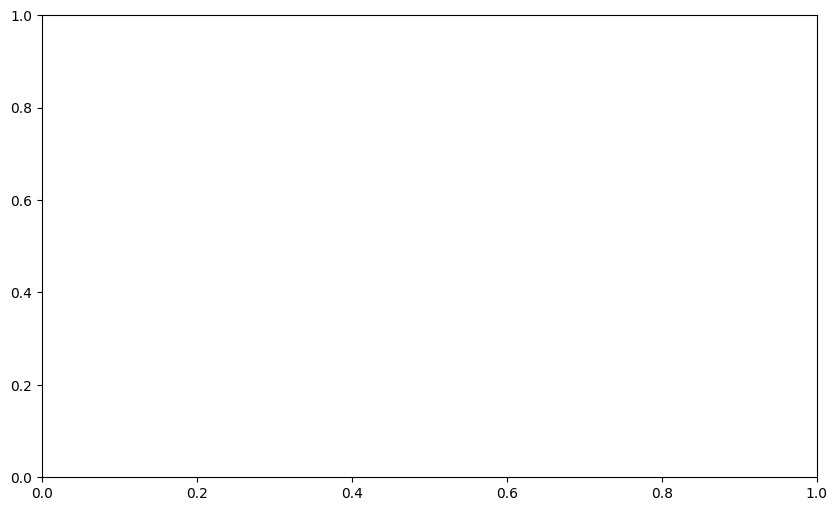

In [ ]:
"""deriving column for gender ratio of men to women
values less than 1 indicate more men than women
values more than 1 indicate more women than men
value exactly at 1 indicates equal population of men and women"""

demographics = demographics.withColumn('GenderRatio', col('Men') / col('Women'))

demographics.select('TractId', 'State', 'County', 'GenderRatio').show()

# collecting data for visualization
gender_ratio_data = demographics.select('GenderRatio').collect()
gender_ratios = [row['GenderRatio'] for row in gender_ratio_data]

# plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(gender_ratios, bins=30, edgecolor='black', color='skyblue')
plt.title('Distribution of Gender Ratios (Men to Women)')
plt.xlabel('Gender Ratio (Men/Women)')
plt.ylabel('Number of Census Tracts')
plt.axvline(x=1, color='red', linestyle='--', label='Equal Population Line')
plt.legend()
plt.grid(True)
plt.show()

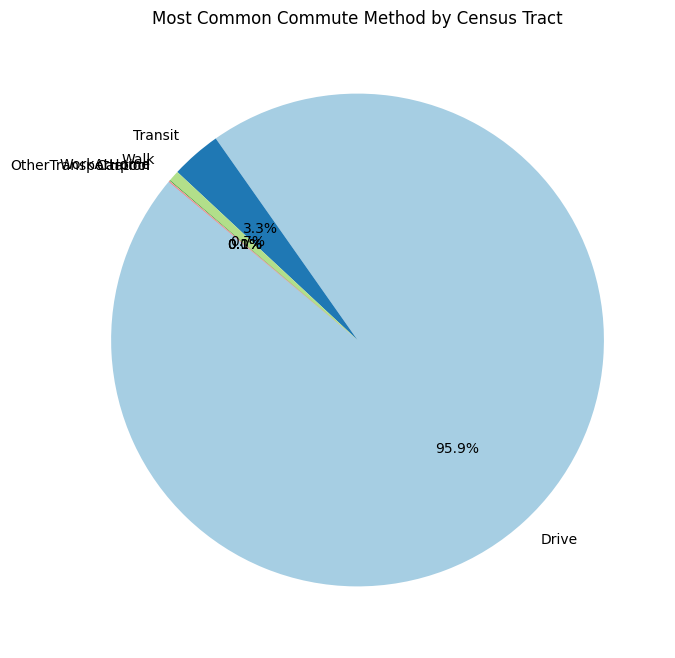

In [ ]:
# deriving column for most common mode of commute
commute_methods = ['Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransportation', 'WorkAtHome']
demographics = demographics.withColumn('DominantCommuteMethod',
                                       when(col('Drive') == greatest(*[col(method) for method in commute_methods]), 'Drive')
                                       .when(col('Carpool') == greatest(*[col(method) for method in commute_methods]), 'Carpool')
                                       .when(col('Transit') == greatest(*[col(method) for method in commute_methods]), 'Transit')
                                       .when(col('Walk') == greatest(*[col(method) for method in commute_methods]), 'Walk')
                                       .when(col('OtherTransportation') == greatest(*[col(method) for method in commute_methods]), 'OtherTransportation')
                                       .when(col('WorkAtHome') == greatest(*[col(method) for method in commute_methods]), 'WorkAtHome'))

# aggregate the data to count the number of tracts for each dominant commute method
commute_counts = demographics.groupBy('DominantCommuteMethod').agg(count('TractId').alias('Count')).orderBy('Count', ascending=False)

# collecting the data
commute_data = commute_counts.collect()
commute_methods = [row['DominantCommuteMethod'] for row in commute_data]
counts = [row['Count'] for row in commute_data]

# plotting a pie chart
plt.figure(figsize=(10, 8))
plt.pie(counts, labels=commute_methods, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Most Common Commute Method by Census Tract')
plt.show()